# Reinforcement Learning

# 7. Parametric Bandits

The objective of this lab is to recommend contents (here movies) using **parametric bandits**. The rewards are binary (like or dislike).


## Imports

In [1]:
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout, VBox, Label

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import spearmanr

You will need ``ipywidgets`` to simulate the interactions with the user.

## Data

We work on a catalogue of 1037 movies available in 2015.

In [2]:
catalogue = pd.read_pickle('movie_database.pickle')
print(f"There are {len(catalogue)} movies in the catalogue.")
display(catalogue.head())

There are 1037 movies in the catalogue.


,Actors,Awards,Country,Director,Genre,Language,Rated,Released,Title,imdbID,imdbRating,Metascore,Box_office,imdbVotes,Runtime,poster
0,"[Mark Hamill, Harrison Ford, Carrie Fisher, Bi...",Won 1 Oscar. Another 15 wins & 18 nominations.,[USA],[Irvin Kershner],"[Action, Adventure, Fantasy]",[English],[PG],1980-06-20,Star Wars: Episode V - The Empire Strikes Back,tt0080684,8.8,79.0,290158751.0,799579.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,"[Kareem Abdul-Jabbar, Lloyd Bridges, Peter Gra...",Nominated for 1 Golden Globe. Another 2 wins &...,[USA],"[Jim Abrahams, David Zucker, Jerry Zucker]",[Comedy],[English],[PG],1980-07-02,Airplane!,tt0080339,7.8,NaN,83400000.0,154994.0,88.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,"[John Belushi, Dan Aykroyd, James Brown, Cab C...",1 win.,[USA],[John Landis],"[Action, Comedy, Crime]",[English],[R],1980-06-20,The Blues Brothers,tt0080455,7.9,NaN,54200000.0,138196.0,133.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,"[Jack Nicholson, Shelley Duvall, Danny Lloyd, ...",3 wins & 5 nominations.,"[USA, UK]",[Stanley Kubrick],"[Drama, Horror]",[English],[R],1980-05-23,The Shining,tt0081505,8.4,61.0,NaN,584323.0,146.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,"[Anthony Hopkins, John Hurt, Anne Bancroft, Jo...",Nominated for 8 Oscars. Another 10 wins & 14 n...,"[USA, UK]",[David Lynch],"[Biography, Drama]",[English],[PG],1980-10-10,The Elephant Man,tt0080678,8.2,NaN,NaN,156572.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


The features are the following:

|Column|Description|Type|
|:---|:---|:---|
|Actors| Actors staring | list of strings|
|Awards| Awards received| string|
|Country| Country of origin| list of strings|
|Director| Director(s) of the movie|  list of strings|
|Genre| Genres (Action, ...) | list of strings|
|Language| Language(s) spoken |list of strings|
|Rated| Public rating (G = General, R = Restricted, ...)| list of strings|
|Released| Date of the movie| date|
|Title|Title of the movie|string|
|imdbID| IMDB id| string|
|imdbRating| IMDB rating (between 0 and 10)| float|
|Metascore| Metacritic score (between 0 and 100)|float|
|Box_office| Total money generated|float|
|imdbVotes| Number of IMDB votes| float|
|Runtime| Duration of the movie (in minutes)|float|
|poster| Poster of the movie (jpg)| binary string|

In [3]:
# Display the posters

def get_poster(k, scale=1):
    return Image(
        value = catalogue.loc[k].poster,
        format = 'jpg',
        width = 130 * scale,
        height = 200 * scale,
    )

def display_posters(index=None, n_col=5, n_rows=4):
    if index is None:
        index = np.arange(len(catalogue))
    if len(index):
        n_rows = min(n_rows, int(np.ceil(len(index) / n_col)))
        grid = GridspecLayout(n_rows, n_col)
        k = 0
        for i in range(n_rows):
            for j in range(n_col):
                if k < len(index):
                    grid[i, j] = get_poster(index[k])
                k += 1 
        return grid

In [4]:
display_posters()

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

## Features

We will describe each movie by some features, for instance its genre.

In [5]:
mlb = MultiLabelBinarizer()
movies = pd.DataFrame(mlb.fit_transform(catalogue['Genre']), columns=mlb.classes_)
display(movies.head())
print(movies.columns)

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western'],
      dtype='object')


## User

Each user will be modeled by a vector of weights (positive or negative) on each feature. 

In [6]:
user1 = pd.DataFrame(0, index = [0], columns=movies.columns)
user1['Action'] = 2
user1['Crime'] = 1
user1['Sci-Fi'] = -2

user2 = pd.DataFrame(0, index = [0], columns=movies.columns)
user2['Action'] = 1
user2['Crime'] = 2
user2['Sci-Fi'] = -1
user2['Drama'] = 1
user2['Thriller'] = 1

## To do

* Display the favorite movies of this user. 
* Test another user, and quantify their similarity (e.g., proportion of common top-100 movies).

In [7]:
def favorite_movies(user: pd.DataFrame):
    """Return the favorite movies of a user in the catalogue, using the user's weights."""
    favorites = (
        (movies @ user.T).rename(columns={0: 'score'})
        .sample(frac=1).sort_values('score', ascending=False)
        .join(catalogue, how='inner')
    )
    return favorites

def similarity(user1: pd.DataFrame, user2: pd.DataFrame, top=100):
    """Return the similarity between two users, as the proportion of common top-n movies."""
    favorites1 = favorite_movies(user1).imdbID.head(n=top)
    favorites2 = favorite_movies(user2).imdbID.head(n=top)
    return len(set(favorites1) & set(favorites2)) / 100


In [8]:
print("--- User 1 ---")
favorite_movies_user1 = favorite_movies(user1)
display(display_posters(favorite_movies_user1[:20].index))

print("--- User 2 ---")
favorite_movies_user2 = favorite_movies(user2)
display(display_posters(favorite_movies_user2[:20].index))

print("--- Similarity ---")
print(f"The similarity between the two users over 100 movies is {similarity(user1, user2, top=100):.2f}.")


--- User 1 ---


GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

--- User 2 ---


GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

--- Similarity ---
The similarity between the two users over 100 movies is 0.60.


## Offline learning

We start with offline learning. There are 2 steps: 
1. Collect the user's opinion on a few movies (e.g., 10)
2. Rank the other movies by logistic regression.

Let's test that.

In [9]:
# Add a column to record the user's opinion (like / dislike)
movies = movies.assign(like=None)

In [10]:
# Select a random movie (not yet seen by the user)
def select_random_movie():
    index = np.flatnonzero(movies.like.isna())
    if len(index):
        return np.random.choice(index)
    else:
        return np.random.choice(len(movies))

# Create buttons
def create_expanded_button(description, button_style):
    return Button(
        description=description,
        button_style=button_style,
        layout=Layout())

def update_likes(button):
    global movie_id
    if button.description == 'like':
        movies.loc[movie_id, 'like'] = True
    elif button.description == 'dislike':
        movies.loc[movie_id, 'like'] = False
    else:
        movies.loc[movie_id, 'like'] = None

def update_poster():
    global movie_id
    img.value = catalogue.loc[movie_id].poster

def on_button_clicked(button):
    global movie_id
    update_likes(button)
    movie_id = select_random_movie()
    update_poster()

In [11]:
# Setting the buttons
left_button = create_expanded_button('like', 'success')
right_button = create_expanded_button('dislike', 'danger')
up_button = create_expanded_button('unknown', 'info')
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)
up_button.on_click(on_button_clicked)

# Setting the movie poster
movies = movies.assign(like=None)
movie_id = select_random_movie()
img = get_poster(movie_id, scale=1.5)

# Display
AppLayout(
    left_sidebar=VBox([left_button], layout=Layout(align_items='center')),
    right_sidebar=VBox([right_button], layout=Layout(align_items='center')),
    center=VBox([up_button, img], layout=Layout(align_items='center')),
    pane_widths=[0.3, 0.4, 0.3]
)

AppLayout(children=(VBox(children=(Button(button_style='success', description='like', style=ButtonStyle()),), …

## To do

* Give your opinion on some movies (e.g., 10), making sure that you get a few likes and a few dislikes.
* Apply logistic regression and display the other movies in order of preference (top movies first).
* Give your top-3 and bottom-3 genres, as predicted by the model.

In [12]:
# Save the user's likes
movies = movies.assign(like=None)
for index in [50, 51, 127, 139, 160, 174, 229, 326, 333, 340, 378, 433, 468, 506,
            938, 1036]:
    movies.loc[index, 'like'] = True
for index in [73,  106,  172,  219,  228,  240,  297,  336,  356,  383,  458,
             511,  540,  603,  639,  661,  735,  771,  794,  810,  870,  890,
             931,  959,  999, 1032]:
    movies.loc[index, 'like'] = False

In [13]:
# likes
likes = np.flatnonzero(movies.like==True)
display_posters(likes)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

In [14]:
# dislikes
dislikes = np.flatnonzero(movies.like==False)
display_posters(dislikes)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

In [15]:
model = LogisticRegression(fit_intercept=False)

# fit the model on the movies seen by the user
X = movies[movies.like.notna()].drop(columns=['like'])
y = movies[movies.like.notna()].like == True
model.fit(X, y)

# predict the likes of the other movies
movies['prediction'] = model.predict_proba(movies.drop(columns='like'))[:, 1]

# display the movies in order of preference for unseen movies
print("--- Top suggestions ---")
display(display_posters(movies[movies.like.isna()].sort_values('prediction', ascending=False).index))
print("\n--- Bottom suggestions ---")
display(display_posters(movies[movies.like.isna()].sort_values('prediction', ascending=True).index))

# top-3 and bottom-3 genres
top_genres = movies.drop(columns=['like', 'prediction']).columns[np.argsort(model.coef_.flatten())[-3:]]
bottom_genres = movies.drop(columns=['like', 'prediction']).columns[np.argsort(model.coef_.flatten())[:3]]
print(f"\n--- Top genres ----\n{', '.join(top_genres)}")
print(f"\n--- Bottom genres ---\n{', '.join(bottom_genres)}")


--- Top suggestions ---


GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…


--- Bottom suggestions ---


GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…


--- Top genres ----
Mystery, Fantasy, Biography

--- Bottom genres ---
Horror, Romance, Comedy


## Online learning

We now learn the user preferences online, as they come. For that, we use a Bayesian algorithm inspired by Thompson sampling. 

On each feedback provided by the user:
1. (Learning) The parameter (vector of weights) is learned.
2. (Sampling) A new parameter is sampled, assuming a Gaussian distribution.
3. (Action) The top movie for this new parameter, among movies not yet seen by the user, is proposed. 

Note that:
* In step 1, we retrain the estimator **from scratch**, using logistic regression on all training data samples (**no** online estimation).
* In step 2, we discard correlations (**diagonal** covariance matrix).

## To do

* Complete the function ``select_bayes`` below.
* Test it on some movies (e.g., 10), until you get a few likes and a few dislikes.
* Display the other movies in order of preference (top movies first).

In [16]:
def select_bayes():

    if set(movies.like) == {True, False, None}:
        # Step 1: learning
        X = movies[movies.like.notna()].drop(columns='like')
        y = movies[movies.like.notna()].like == True
        model = LogisticRegression(fit_intercept=False)
        model.fit(X, y)

        # Step 2: sampling
        theta_hat = model.coef_.flatten()
        sigma = np.full_like(theta_hat, 0.1)
        theta_sampled = np.random.normal(theta_hat, sigma)

        # Step 3: action
        unseen_movies = movies[movies.like.isna()].drop(columns='like')
        scores = unseen_movies @ theta_sampled
        top_movie_ids = scores.idxmax()

        return top_movie_ids
    
    else:
        return select_random_movie()

def on_button_clicked(button):
    global movie_id
    update_likes(button)
    movie_id = select_bayes()
    update_poster()

In [17]:
# reset
movies = movies.assign(like=None)
movies = movies.assign(prediction=None).drop(columns='prediction')

# Setting the buttons
left_button = create_expanded_button('like', 'success')
right_button = create_expanded_button('dislike', 'danger')
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

# Setting the movie poster
movie_id = select_random_movie()
img = get_poster(movie_id, scale=1.5)

# Display
AppLayout(
    left_sidebar=VBox([left_button], layout=Layout(align_items='center')),
    right_sidebar=VBox([right_button], layout=Layout(align_items='center')),
    center=VBox([img], layout=Layout(align_items='center')),
    pane_widths=[0.3, 0.4, 0.3]
)

AppLayout(children=(VBox(children=(Button(button_style='success', description='like', style=ButtonStyle()),), …

In [18]:
# Save the user's likes
movies = movies.assign(like=None)
for index in [50, 51, 127, 139, 160, 174, 229, 326, 333, 340, 378, 433, 468, 506,
            938, 1036]:
    movies.loc[index, 'like'] = True
for index in [73,  106,  172,  219,  228,  240,  297,  336,  356,  383,  458,
             511,  540,  603,  639,  661,  735,  771,  794,  810,  870,  890,
             931,  959,  999, 1032]:
    movies.loc[index, 'like'] = False

In [19]:
print(movies['like'].value_counts())
print(movies[movies.like.isna()].shape[0])

False    26
True     16
Name: like, dtype: int64
995


## Analysis

Finally, we would like to assess the quality of our bandit algorithm.

## To do

* Choose a user, that is a parameter $\theta$ (vector of weights).
* Provide the answers of this user to the movies proposed by the algorithm, assuming binary rewards, with mean
$$
q(a) = \frac 1 {1 + e^{-\theta^T a}}
$$
where $a$ is the action (= movie proposed by the algorithm).
* Make sure that a reasonable fraction of movies are liked (e.g., between 10\% and 90\%). Otherwise, update $\theta$.
* Simulate an interaction of this user with the recommender system over 100 movies.
* Compute the [Spearman's correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) of the ranking of the unseen movies provided by the algorithm, compared to the ground-truth ranking.
* Plot the evolution of this coefficient with respect to the number of movies seen by the user, from 1 to 100.
* Give the top-3 and bottom-3 genres, as predicted by the model, and compare to the ground-truth.
* Do the same experiments with other features (e.g., actors, actors + genres, actors + director + genres).

In [20]:
# Choose a user
movies = movies.assign(like=None).drop(columns=['like'])
user = pd.DataFrame(0, index = [0], columns=movies.columns)

# simulate a child user for example
user['Adventure'] = 1
user['Animation'] = 5
user['Comedy'] = 3
user['Family'] = 2
user['Fantasy'] = 1
user['Drama'] = -1
user['Horror'] = -4
user['Mystery'] = -2
user['Sci-Fi'] = -1
user['Thriller'] = -2
user['War'] = -5
user['Western'] = -1

The user likes 51% of the movies.


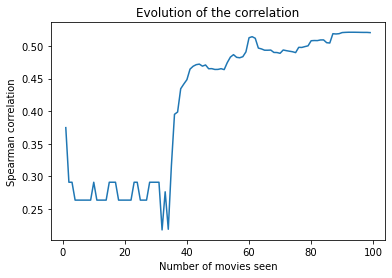


--- Top genres predicted----
Comedy, Adventure, Family

--- Bottom genres predicted ---
Thriller, Crime, Drama

--- Top genres ground-truth ----
Family, Comedy, Animation

--- Bottom genres ground-truth ---
War, Horror, Thriller


In [21]:
# Binary rewards
def binary_reward(a, theta):
    return np.random.rand() < 1 / (1 + np.exp(-a @ theta))

# Simulate an interaction
movies = movies.assign(like=None).drop(columns=['like'])
theta = user.values.flatten()
ground_truth = movies.apply(lambda a: binary_reward(a, theta), axis=1)
gt_score = pd.Series(movies.values @ theta)
gt_rank = ground_truth.rank(ascending=False, method='first')
print(f"The user likes {ground_truth.mean():.0%} of the movies.")

movies = movies.assign(like=None)
correlations = []
for i in range(100):
    movie_id = select_bayes()
    movies.loc[movie_id, 'like'] = ground_truth[movie_id]

    try:
        # Get parameters of trained model
        X = movies[movies.like.notna()].drop(columns='like')
        y = movies[movies.like.notna()].like == True
        model = LogisticRegression(fit_intercept=False)
        model.fit(X, y)
        theta_hat = model.coef_.flatten()
        like_score = pd.Series(movies.drop(columns='like').values @ theta_hat)

        # Spearman's correlation coefficient
        like_rank = like_score.rank(ascending=False, method='first')
        correlation = spearmanr(gt_rank, like_rank)
        correlations.append(correlation.correlation)
    except:
        correlations.append(np.nan)

# Plot the evolution of the correlation
import matplotlib.pyplot as plt
plt.plot(correlations)
plt.xlabel('Number of movies seen')
plt.ylabel('Spearman correlation')
plt.title('Evolution of the correlation')
plt.show()

# Top-3 and bottom-3 genres
top_genres = movies.drop(columns='like').columns[np.argsort(theta_hat)[-3:]]
bottom_genres = movies.drop(columns='like').columns[np.argsort(theta_hat)[:3]]
print(f"\n--- Top genres predicted----\n{', '.join(top_genres)}")
print(f"\n--- Bottom genres predicted ---\n{', '.join(bottom_genres)}")

# Top-3 and bottom-3 genres ground-truth
top_genres = movies.drop(columns='like').columns[np.argsort(theta)[-3:]]
bottom_genres = movies.drop(columns='like').columns[np.argsort(theta)[:3]]
print(f"\n--- Top genres ground-truth ----\n{', '.join(top_genres)}")
print(f"\n--- Bottom genres ground-truth ---\n{', '.join(bottom_genres)}")